### Monte Carlo NVT

Lo scopo di questo esercizio è di simulare il sistema già affrontato nell’esercitazione di Dinamica Molecolare, ossia 108 particelle interagenti con potenziale di Lennard-Jones, fissando la temperatura del sistema e campionando la posizione delle particelle con l’algoritmo di Metropolis. 
Anche in questo esercizio ho implementato un codice preformato per soddisfare le richieste.

Innanzitutto ho implementato lo studio della funzione di autocorrelazione. Infatti, dal momento che il metodo di Metropolis è una catena di Markov, la correlazione potrebbe essere molto forte tra steps vicini.

La funzione di autocorrelazione è così definita:

$$ \chi(\tau) = 
\frac{\langle x(t)\,x(t+\tau)\rangle  - \langle x(t)\rangle \langle x(t+\tau)\rangle}{{\sigma^2}_x} $$

dove x(t) sono le posizioni al tempo t (in un metodo tipo Metropolis t è discreto e coincide con gli steps MC), e ${\sigma^2}_x$ è la varianza del dataset utilizzato per calcolare l’autocorrelaizone. 
Ho implementato un script python che la calcola usando un dataset di 100000 valori istantanei per l’energia e la pressione. La simulazione ha 101000 steps totali, ma nella lettura del file i primi 1000 steps sono saltati, in modo da prendere in considerazione i valori di energia solo dopo che il sistema è equilibrato. 
Ho calcolato l’autocorrelazione per valori di $\tau$ da 1 a 500.
È importante sapere quando l’autocorrelazione tende a zero, così da avere una indicazione su quanto devono essere grandi i blocchi del  Data Blocking, in modo da fornire una stima reale dell’errore.

Nelle seguenti figure mostro i plot delle funzioni di autocorrelazione per le tre fasi: solida, liquida e gassosa. È chiaro che per ogni fase c’è un valore di steps dopo i quali l’autocorrelaizone scompare completamente. Osservanodo i grafici concludo che per la fase solida, è opportuno scegliere dei blocchi più grandi di 100 steps. Per la fase liquida indico come limite inferiore 250 steps, mentre per quella gassosa già a 50 steps noto che l'autocorrelazione è praticamente 0.
utilizzando blocchi con dimensione > 300 steps, non ci saranno effetti sulla stima dell’errore. Inoltre ho implementato un semplice fit sulle curve ottenute per dimostrare che il loro andamento è esponenziale decresente, rendendo disponibile il valore del tempo caratteristico per ciascuna situazione.

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.subplot.wspace'] = 0.2
mpl.rcParams['figure.subplot.hspace']= 0.4

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def mean (x, size):
    ave = 0
    for i in range(0,size):
        ave = ave + x[i]
    return ave/size

def error (x, size):
    ave = mean (x,size)
    ave2 = mean (x*x, size)
    return ave2 - ave**2

#funzione che calcola la autocorrelazione vedi mail Mambro
def autocorr (x,size):
    auto = np.zeros(size)
    ave = mean(x, x.size-size)
    sigma = error(x, x.size)

    for t in range(0,size):
        covxx = 0
        meanplus = 0
        
        for t1 in range(0, x.size-size):
            covxx = covxx + x[t1]*x[t1+t]
            meanplus = meanplus + x[t1+t]
        meanplus = meanplus/(x.size-size)
        covxx = covxx/(x.size - size)
        auto[t] = (covxx - meanplus*ave)/sigma
    return auto            

s_epot, s_press = np.loadtxt("./MonteCarlo_NVT/solid/U_P_instant_solid.txt", usecols=(0,1), unpack=True, skiprows=1001)
l_epot, l_press = np.loadtxt("./MonteCarlo_NVT/liquid/U_P_instant_liquid.txt", usecols=(0,1), unpack=True, skiprows=1001)
g_epot, g_press = np.loadtxt("./MonteCarlo_NVT/gas/U_P_instant_gas.txt", usecols=(0,1), unpack=True, skiprows=1001)

ac_s_epot = autocorr(s_epot,500)
ac_s_press = autocorr (s_press,500)
ac_l_epot = autocorr(l_epot,500)
ac_l_press = autocorr (l_press,500)
ac_g_epot = autocorr(g_epot,500)
ac_g_press = autocorr (g_press,500)

Solid epot [N, t_c] [0.89368801 9.25762183]
Solid press [N, t_c] [0.8963292 9.0568248]
Liquid epot [N, t_c] [ 0.70273425 15.62577017]
Liquid press [N, t_c] [ 0.67210976 22.1699146 ]
Gas epot [N, t_c] [0.86129315 6.35960715]
Gas press [N, t_c] [0.99750102 0.97996408]


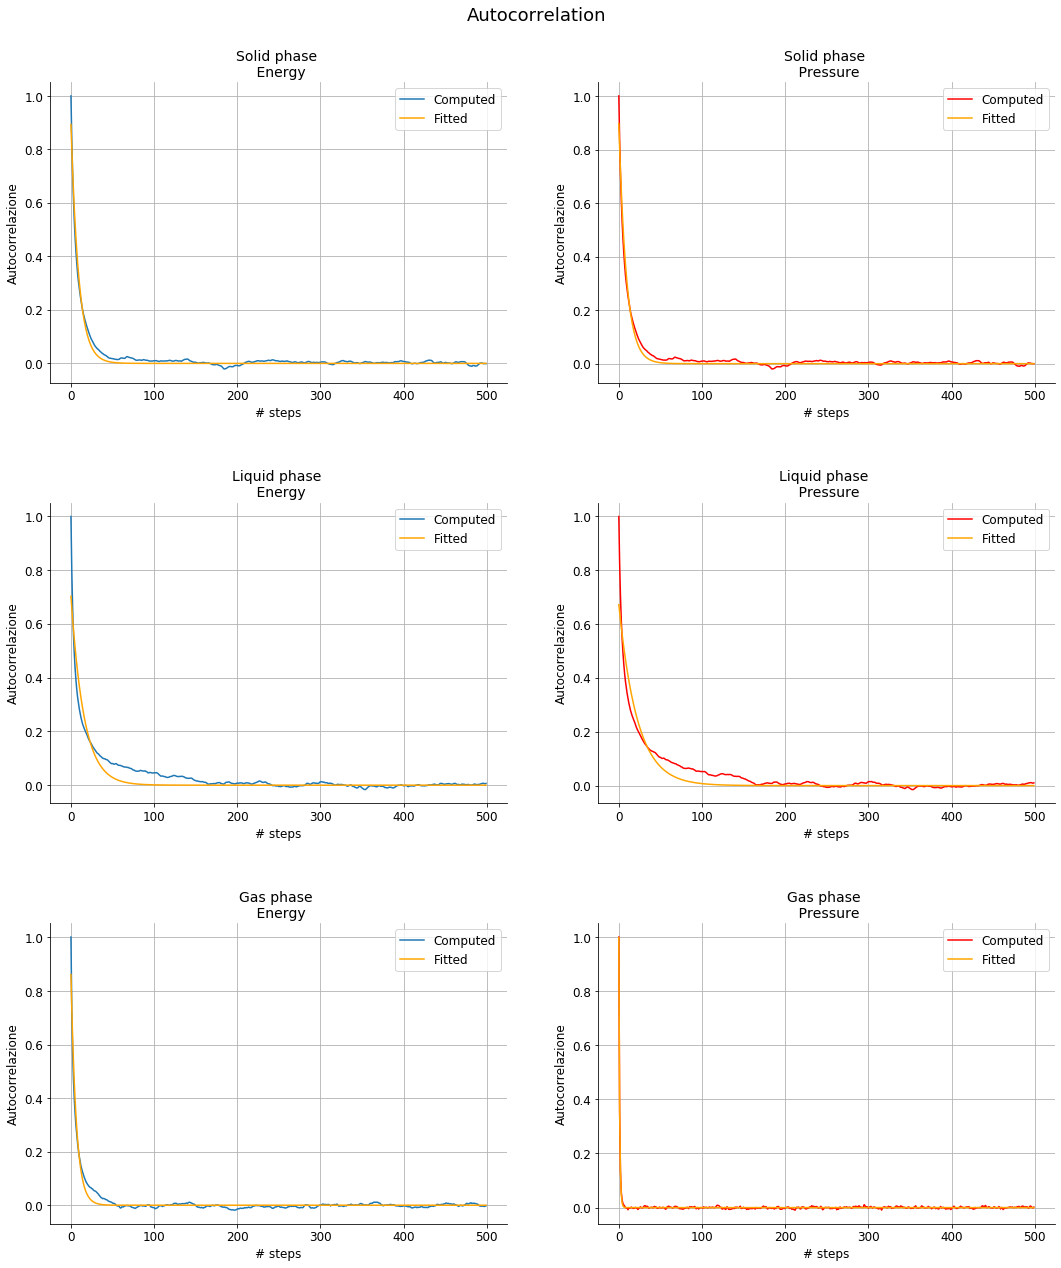

In [2]:
from scipy.optimize import curve_fit
def f (x,a, tau):
    return a*np.exp(-x/tau)
n = np.arange (0, ac_s_epot.size)


fig, axarr = plt.subplots (3 ,2, figsize=(18,21))
fig.suptitle("Autocorrelation", y=0.93)

n = np.arange (0, ac_s_epot.size)

#Solid phase

axarr[0,0].plot (n, ac_s_epot, label  = "Computed")
axarr[0,0].set_title ("Solid phase \n Energy")
axarr[0,1].plot (n, ac_s_press, label  = "Computed", c = 'red')
axarr[0,1].set_title ("Solid phase \n Pressure")

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_s_epot)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[0,0].plot(n,y_fit, c='orange', label="Fitted")

print("Solid epot [N, t_c]", p_opt)


#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_s_press)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[0,1].plot(n,y_fit, c='orange', label="Fitted")

print("Solid press [N, t_c]", p_opt)


#Liquid phase

axarr[1,0].plot (n, ac_l_epot, label  = "Computed")
axarr[1,0].set_title ("Liquid phase \n Energy")
axarr[1,1].plot (n, ac_l_press, label  = "Computed", c = 'red')
axarr[1,1].set_title ("Liquid phase \n Pressure")

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_l_epot)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[1,0].plot(n,y_fit, c='orange', label="Fitted")

print("Liquid epot [N, t_c]", p_opt)

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_l_press)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[1,1].plot(n,y_fit, c='orange', label="Fitted")

print("Liquid press [N, t_c]", p_opt)


#Gas phase

axarr[2,0].plot (n, ac_g_epot, label  = "Computed")
axarr[2,0].set_title ("Gas phase \n Energy")
axarr[2,1].plot (n, ac_g_press, label  = "Computed", c = 'red')
axarr[2,1].set_title ("Gas phase \n Pressure")

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_g_epot)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[2,0].plot(n,y_fit, c='orange', label="Fitted")

print("Gas epot [N, t_c]", p_opt)

#fit parameters
p_opt, p_cov = curve_fit (f, n, ac_g_press)
y_fit = f(n, p_opt[0], p_opt[1])
axarr[2,1].plot(n,y_fit, c='orange', label="Fitted")

print("Gas press [N, t_c]", p_opt)

for i in range(3):
    for j in range(2):
        axarr[i, j].set_xlabel ('# steps')
        axarr[i, j].set_ylabel("Autocorrelazione")
        axarr[i, j].grid(True)
        axarr[i, j].legend()


plt.show()

Un’altra importante proprietà che dipende fortemente dalla lunghezza dei blocchi è l’incertezza statistica. Utilizzare dei blocchi troppo corti per il metodo del data blocking non fornisce un errore corretto a causa della poca statistica sulla quale viene calcolato. D’altro canto, usare senza criterio dei blocchi enormi, farebbe aumentare senza ragione il costo computazionale dell’algoritmo. 
Per questo motivo, utilizzando i medesimi dati della autocorrelazione, ho calcolato i valori attesi delle incertezze di blocco al variare dalla dimensione dei blocchi. 
Per fare ciò ho scritto uno script python che divide le misure in blocchi, accumula medie e medie quadrate sui blocchi e alla fine calcola l’errore statistico via Data blocking, nel seguente modo:

$$
\sigma = \sqrt{\frac{\langle  x^2\rangle - \langle x \rangle^2}{N-1}}
$$

dove x è il valore medio di una certa grandezza in un blocco e N è il numero totale di blocchi.

Nelle seguenti figure ci sono i valori degli errori in funzione di L, dove L 100000/N (N = numero di blocchi).

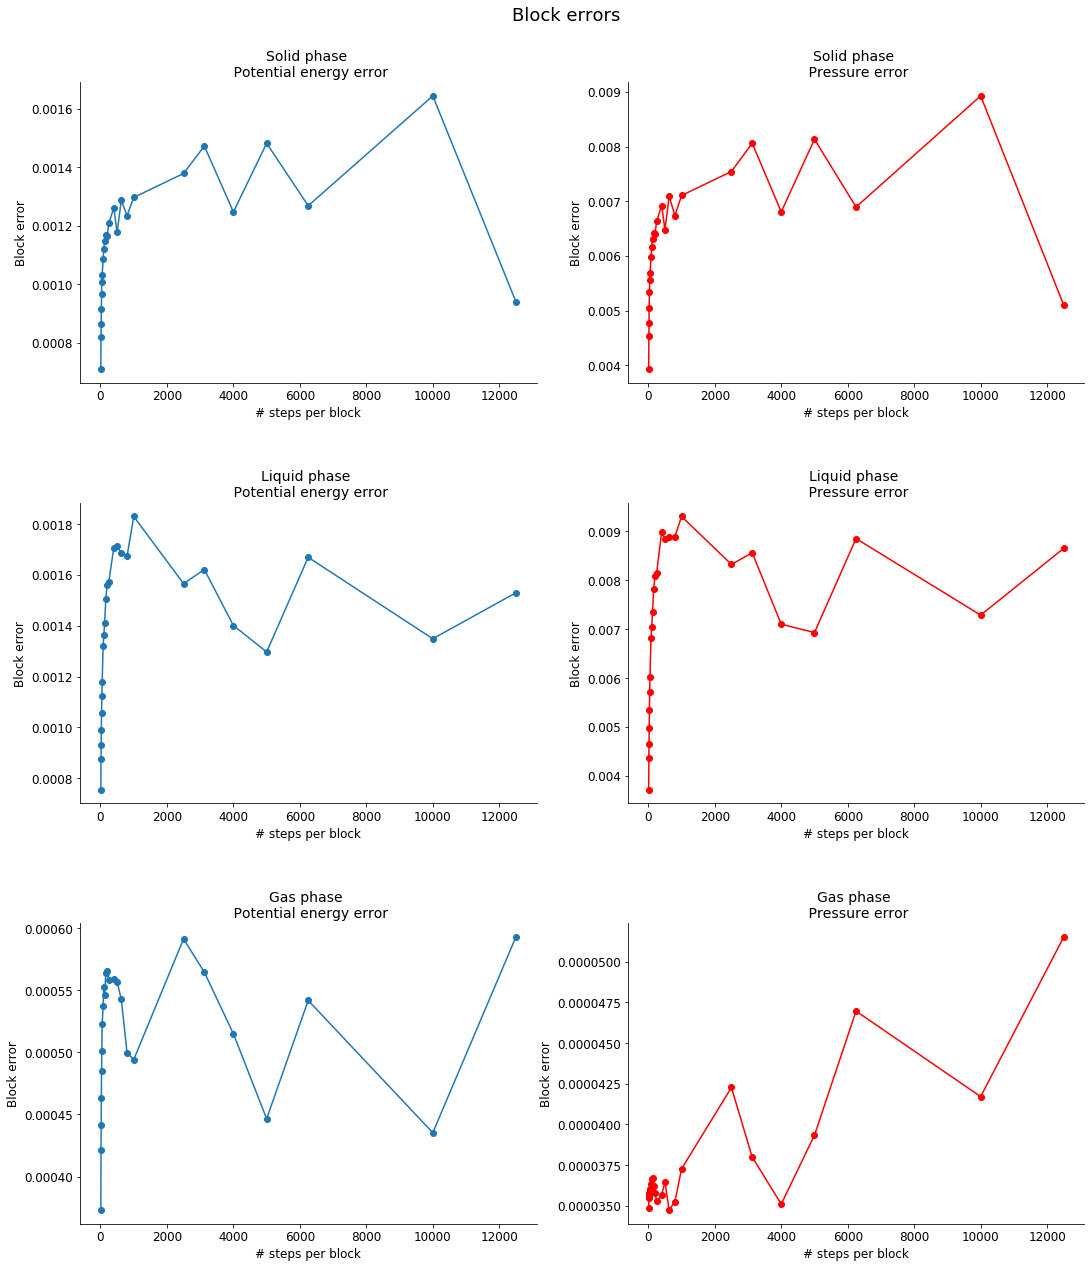

In [3]:
#Studio dell'incertezza statistica
def stat_error (x, L):
    #x è il seti di valori su cui calcolare l'errore
    #L: numeri di valori contenuti in ogni blocco
    #per verificare la dimensione del vettore sia un multiplo intero di L
    assert x.size%L == 0
    N = x.size/L
    N = int(N)
    ave = mean(x,x.size)
    ave_2 = 0
    for i in range(0,N):
        ave_2 = ave_2 + mean(x[i*L:(i+1)*L:1],L)**2
    ave_2 = ave_2/N
    #restituisco l'errore statistico con il data blocking per i L valori contenuti in un blocco
    return ((ave_2-ave**2)/(N-1))**0.5
        
L_values = [10,16,20,25,32,40,50,80,100,125,160,200,250,400,500,625,800,1000,2500, 3125, 4000, 5000, 6250, 10000,12500]

#Solid phase
s_epot_err = np.array([
    stat_error(s_epot,L)
    for L in L_values
])

s_press_err = np.array([
    stat_error(s_press,L)
    for L in L_values
])

#Liquid phase
l_epot_err = np.array([
    stat_error(l_epot,L)
    for L in L_values
])

l_press_err = np.array([
    stat_error(l_press,L)
    for L in L_values
])

#Gas phase
g_epot_err = np.array([
    stat_error(g_epot,L)
    for L in L_values
])

g_press_err = np.array([
    stat_error(g_press,L)
    for L in L_values
])

fig, axarr = plt.subplots (3 ,2, figsize=(18,21))
fig.suptitle("Block errors", y=0.93)
axarr[0,0].plot (L_values, s_epot_err, marker='o')
axarr[0,1].plot (L_values, s_press_err, c='red', marker='o')
axarr[0,0].set_title("Solid phase \n Potential energy error")
axarr[0,1].set_title("Solid phase \n Pressure error")

axarr[1,0].plot (L_values, l_epot_err, marker='o')
axarr[1,1].plot (L_values, l_press_err, c='red', marker='o')
axarr[1,0].set_title("Liquid phase \n Potential energy error")
axarr[1,1].set_title("Liquid phase \n Pressure error")

axarr[2,0].plot (L_values, g_epot_err, marker='o')
axarr[2,1].plot (L_values, g_press_err, c='red', marker='o')
axarr[2,0].set_title("Gas phase \n Potential energy error")
axarr[2,1].set_title("Gas phase \n Pressure error")

for i in range(3):
    for j in range(2):
        axarr[i, j].set_xlabel ('# steps per block')
        axarr[i, j].set_ylabel("Block error")
                               
plt.show()

Dai grafici del Block error in funzione della block size $L$ noto che l'errore tende a crescere fino  diventare costante e indipendente dalla block size. 
Osservo che nel caso della fase solida, sia per la pressione che per l'energia, superati i 1000 dati per blocco non è più presente un trend nell'andamento del grafico e il valore dell'errore si stabilizza. Per la fase gassosa osservo che già dopo 200 steps per blocco il valore è stabile, mentre per il liquido sembra stabilizzarsi dopo 5000 steps. 
In primo luogo questi risultati sono in accordo con il numero di steps a cui la correlazione diventa zero per le tre fasi. Prima (in termini di steps) la autorcorrelazione va a 0, minore è il numero di dati richiesti in ciascun blocco affinchè l'errore si stabilizzi attorno al vero valore statistico. Come per l'autocorrelazione tra le tre fasi, chi si scorrelava prima era il gas, seguito dal solido e poi dal liquido, così la fase che richiede meno steps per rendere l'errore stabile è quella gassosa, seguitoa dal solido e poi dal liquido.
Come detto prima questo succede perché l'autocorrelazione causa una sottostima dell'errore.
In secondo luogo, i grafici confermano che una volta che l'errore statistico vero è stato raggiunto, anche aumentando la dimensione dei blocchi, non cambia più il valore dell'errrore, infatti viene soddisfatto il Teorema del limite centrale.

Quindi per avere blocchi scorrelati e quindi per non sottostimare l'errore statistico si impone che la dimensione del blocco debba essere di molti tempi di correlazione e in queste condizioni si eseguirà la simulazione vera e propria.

Prima di far partire la simulazione verifico che il sistema sia equilibrato, riportando i valori in unità LJ di energia e pressione. Riporto i primi 5000 valori istantanei che confermano che l'equilibrazione è avvenuta, poichè i grafici si stabilizzano attorno ad un valore di riferimento.

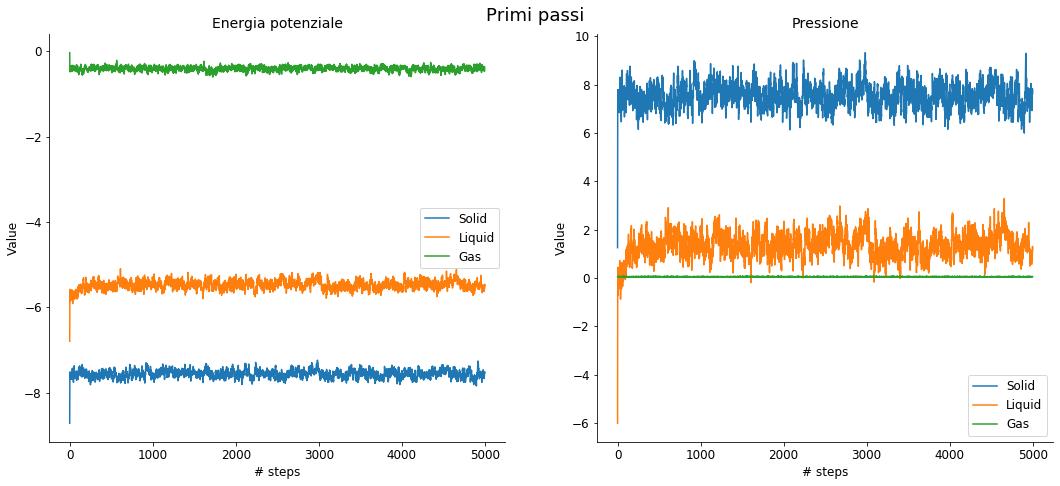

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

s_epot, s_press = np.loadtxt("./MonteCarlo_NVT/solid/U_P_instant_solid.txt", usecols=(0,1), unpack=True, max_rows=5000)
l_epot, l_press = np.loadtxt("./MonteCarlo_NVT/liquid/U_P_instant_liquid.txt", usecols=(0,1), unpack=True, max_rows=5000)
g_epot, g_press = np.loadtxt("./MonteCarlo_NVT/gas/U_P_instant_gas.txt", usecols=(0,1), unpack=True, max_rows=5000)

fig, axarr = plt.subplots (1 ,2, figsize=(18,7.5))
fig.suptitle("Primi passi", y=0.93)

n = np.arange(s_epot.size)
axarr[0].plot(n, s_epot, label='Solid')
axarr[0].plot(n, l_epot, label='Liquid')
axarr[0].plot(n, g_epot, label='Gas')
axarr[0].set_title('Energia potenziale')
axarr[0].set_xlabel("# steps")
axarr[0].set_ylabel("Value")
axarr[0].legend()

axarr[1].plot(n, s_press, label='Solid')
axarr[1].plot(n, l_press, label='Liquid')
axarr[1].plot(n, g_press, label='Gas')
axarr[1].set_title('Pressione')
axarr[1].set_xlabel("# steps")
axarr[1].set_ylabel("Value")
axarr[1].legend()
plt.show()

Ora il sistema è pronto per avviare la vera e propria simulazione sull'Argon nelle tre configurazioni (solido, liquido e gas). Imposto, tenendo conto di tutte le considerazioni precedenti su correlazione ed errore statistico, 20 blocchi da 6000 step ciascuno.
Il codice carica come configurazione iniziale del sistema l'ultima della fase di equilibrazione, salvata nel file config.final. RIporto i risultati ottenuti.

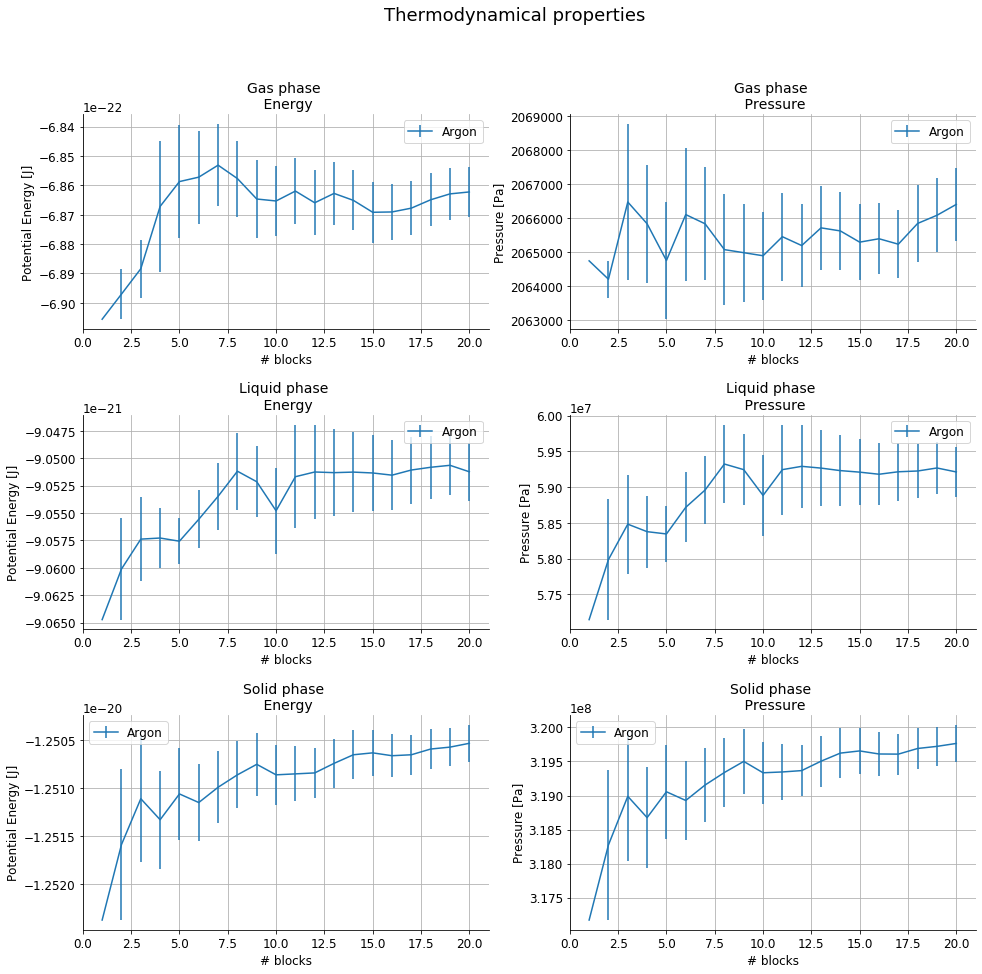

In [5]:
fig, axarr = plt.subplots (3 ,2, figsize=(16,15))
fig.suptitle("Thermodynamical properties")

#gas
blk, a_epot, a_epot_err = np.loadtxt("./MonteCarlo_NVT/gas/output.epot_gas.0", usecols=(0, 2, 3), unpack=True)
axarr[0,0].errorbar(blk, a_epot, yerr=a_epot_err, label='Argon')
axarr[0,0].set_title ("Gas phase \n Energy")

blk, a_press, a_press_err = np.loadtxt("./MonteCarlo_NVT/gas/output.pres_gas.0", usecols=(0, 2, 3), unpack=True)
axarr[0,1].errorbar(blk, a_press, yerr=a_press_err, label='Argon')
axarr[0,1].set_title ("Gas phase \n Pressure")

axarr[0,0].set_ylabel("Potential Energy [J]")
axarr[0,1].set_ylabel("Pressure [Pa]")

#liquid
blk, a_epot, a_epot_err = np.loadtxt("./MonteCarlo_NVT/liquid/output.epot_liquid.0", usecols=(0, 2, 3), unpack=True)
axarr[1,0].errorbar(blk, a_epot, yerr=a_epot_err, label='Argon')
axarr[1,0].set_title ("Liquid phase \n Energy")

blk, a_press, a_press_err = np.loadtxt("./MonteCarlo_NVT/liquid/output.pres_liquid.0", usecols=(0, 2, 3), unpack=True)
axarr[1,1].errorbar(blk, a_press, yerr=a_press_err, label='Argon')
axarr[1,1].set_title ("Liquid phase \n Pressure")


axarr[1,0].set_ylabel("Potential Energy [J]")
axarr[1,1].set_ylabel("Pressure [Pa]")

#solid
blk, a_epot, a_epot_err = np.loadtxt("./MonteCarlo_NVT/solid/output.epot_solid.0", usecols=(0, 2, 3), unpack=True)
axarr[2,0].errorbar(blk, a_epot, yerr=a_epot_err, label='Argon')
axarr[2,0].set_title ("Solid phase \n Energy")

blk, a_press, a_press_err = np.loadtxt("./MonteCarlo_NVT/solid/output.pres_solid.0", usecols=(0, 2, 3), unpack=True)
axarr[2,1].errorbar(blk, a_press, yerr=a_press_err, label='Argon')
axarr[2,1].set_title ("Solid phase \n Pressure")

axarr[2,0].set_ylabel("Potential Energy [J]")
axarr[2,1].set_ylabel("Pressure [Pa]")

for i in range(3):
    for j in range(2):
        axarr[i,j].set_xlabel("# blocks")
        axarr[i,j].set_xlim((0,21))
        axarr[i,j].grid(True)
        axarr[i,j].legend()
plt.show()

Infine studio l'andamento della funzione di distribuzione radiale g(r) ottenuta mediante Monte Carlo e Molecular Dynamics. Anche in questo caso ho deciso di impostare 6000 steps per blocco per 20 blocchi, quindi 120000 steps. Dopo aver equilibrato i sistemi, nelle modalità indicate predentemente per Monte Carlo e nella esercitazione 4 per dinamica molecolare, ho ottenuto i seguenti risultati.

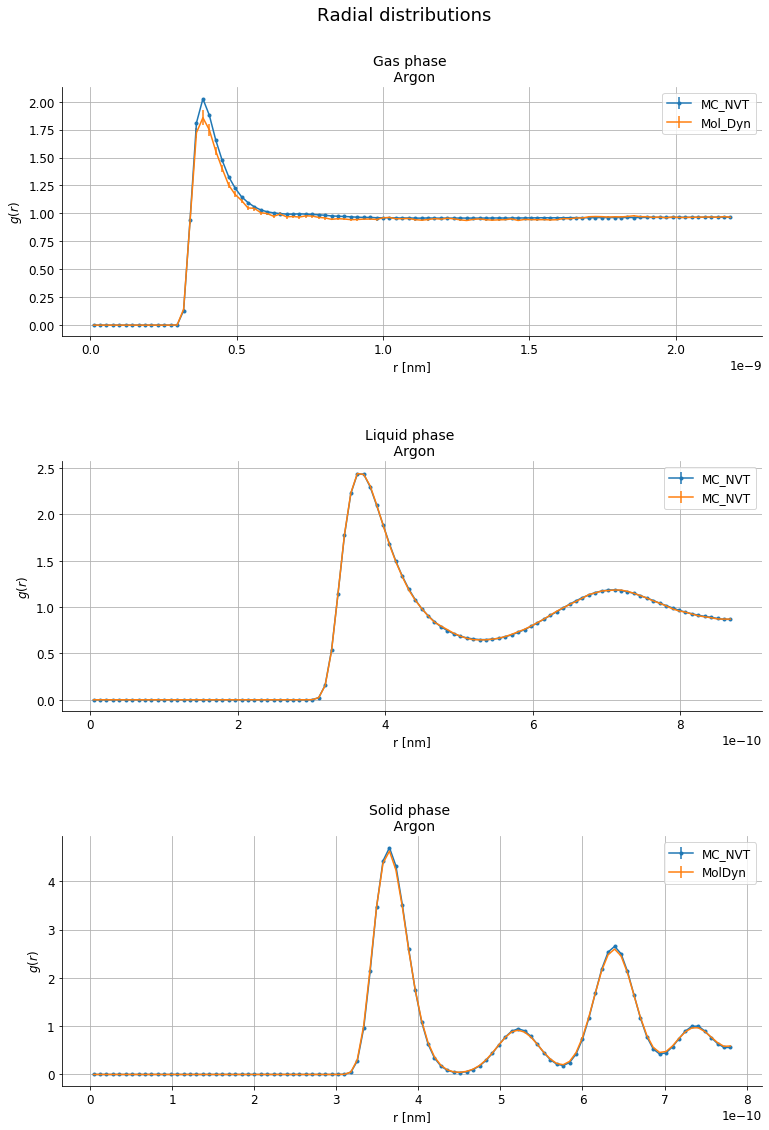

In [6]:

fig, axarr = plt.subplots (3 ,1, figsize=(13,17))
fig.suptitle("Radial distributions")
fig.tight_layout(pad=10.0)

#gas
r, g , error= np.loadtxt("./MonteCarlo_NVT/gas/output.gave_gas.0", usecols=(0, 1, 2), unpack=True)
m_r, m_g , m_error= np.loadtxt("./MonteCarlo_NVT/g(r)MD/ave_gdir_gas.out", usecols=(0, 1, 2), unpack=True)
axarr[0].errorbar(r,g, yerr=error, label='MC_NVT', marker='.')
axarr[0].errorbar(m_r,m_g, yerr=m_error, label='Mol_Dyn')
axarr[0].set_title ("Gas phase \n Argon")

#liquid
r, g , error= np.loadtxt("./MonteCarlo_NVT/liquid/output.gave_liquid.0", usecols=(0, 1, 2), unpack=True)
m_r, m_g , m_error= np.loadtxt("./MonteCarlo_NVT/g(r)MD/ave_gdir_liquid.out", usecols=(0, 1, 2), unpack=True)

axarr[1].errorbar(r,g, yerr=error, label='MC_NVT', marker='.')
axarr[1].errorbar(m_r,m_g, yerr=m_error, label='MC_NVT')
axarr[1].set_title ("Liquid phase \n Argon")

#solid
r, g , error= np.loadtxt("./MonteCarlo_NVT/solid/output.gave_solid.0", usecols=(0, 1, 2), unpack=True)
m_r, m_g , m_error= np.loadtxt("./MonteCarlo_NVT/g(r)MD/ave_gdir_solid.out", usecols=(0, 1, 2), unpack=True)

axarr[2].errorbar(r,g, yerr=error, label='MC_NVT', marker='.')
axarr[2].errorbar(m_r,m_g, yerr=m_error, label='MolDyn')
axarr[2].set_title ("Solid phase \n Argon")

for i in range(3):
        axarr[i].set_xlabel("r [nm]")
        axarr[i].set_ylabel(r"$g(r)$")
        axarr[i].grid(True)
        axarr[i].legend()
plt.show()

I dati sono in perfetto accordo, tranne che nel caso del gas. Forse questo è dovuto al fatto che nel metodo di dinamica molecolare - algoritmo di Verlet - ho utilizzato il medesimo *dt* per tutte le fasi. Tuttavia nella fase gassosa, le particelle sono molto più veloci e questo può aver dato luogo ad un errore maggiore nel calcolo della loro posizione dalle equazioni del moto. Il problema non sussiste nel caso del Metropolis, dal momento che con questo metodo non si campionano delle traiettorie reali, ma direttamente la distribuzione di probabilità.